# Testing Notebook

### Imports and Data Input

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
import time
# import data_files

"""Import Data"""
# data = data_files.runs_dict

'Import Data'

In [6]:
"""Display summary of all available data"""
# data_files.file_summary

'Display summary of all available data'

In [33]:
file_path = 'data/L230414.CSV'
rows = range(300,3300)
df = pd.read_csv(file_path, skiprows=range(1,rows[0]), nrows=len(rows))

,Date,Time,Lat,Lon,Speed m/s,Distance km,RPM 1,Motor Load 1 %,Motor Torque 1 %,Motor Temp 1 C,...,Pack Temp 2 C,SOC 2 %,Pack Current 3 A,Pack Voltage 3 V,Pack Temp 3 C,SOC 3 %,Pack Current 4 A,Pack Voltage 4 V,Pack Temp 4 C,SOC 4 %
0,23-04-14,14:37:47,45.476391,-122.661888,2.721381,0.181500,759,1,10,28.290001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
1,23-04-14,14:37:48,45.476379,-122.661888,2.740820,0.182900,759,1,10,28.290001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
2,23-04-14,14:37:49,45.476368,-122.661888,2.818574,0.184330,760,1,10,28.200001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
3,23-04-14,14:37:50,45.476353,-122.661888,2.779697,0.185770,760,1,10,28.290001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
4,23-04-14,14:37:51,45.476452,-122.661888,2.682505,0.187170,760,1,10,28.290001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,23-04-14,15:27:44,45.476360,-122.660789,0.233261,10.060115,0,0,0,30.700001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
2996,23-04-14,15:27:45,45.476360,-122.660789,0.233261,10.060235,0,0,0,30.790001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
2997,23-04-14,15:27:46,45.476360,-122.660789,0.272138,10.060375,0,0,0,30.790001,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
2998,23-04-14,15:27:47,45.476360,-122.660789,0.291577,10.060525,0,0,0,30.600000,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0


### Dashboard of Chosen Run

KeyError: 'Speed kts'

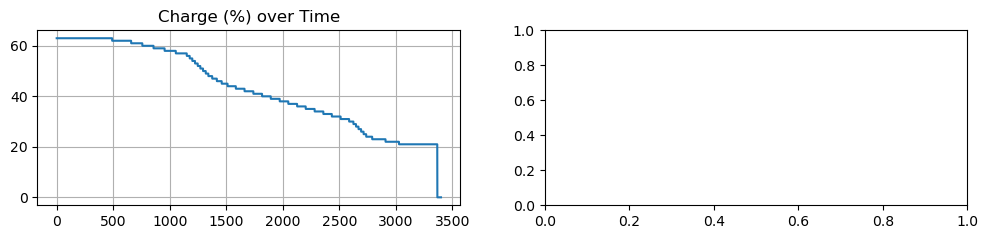

In [7]:
"""Pick a run and show overview of interesting data"""

# run = 31
# df = data['Run %i' % run]
# print(data_files.file_summary.iloc[run-1])  # print summary values of run

'''Summary Plots'''
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.plot(df.index, df['SOC 1 %'])
plt.grid()
plt.title('Charge (%) over Time')

plt.subplot(2,2,2)
plt.plot(df.index, df['Speed kts'], df['Power 1 kW'])
plt.grid()
plt.title('Power (kW) and Speed (kts) over Time')

plt.subplot(2,2,3)
plt.plot(df.index, df['Pack Voltage 1 V'], df['Pack Current 1 A'])
plt.grid()
plt.title('Current and Voltage over Time')

# plt.subplot(2,2,4)
# plt.plot(df.index)
# plt.grid()
# plt.title('Empty')

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.3)

df.head()

# Testing Class

In [ ]:
class testing():

    def __init__(self):
        self.data = {
            'sog': 0,               # Knot, COG SOG Rapid Update
            'rpm': 0,               # RPM, Engine Parameters Rapid Update
            'date': "12:34 PM",     # GNSS Position Data
            'time': "12:34 PM",     # GNSS Position Data
            'cog': 0,               # Deg, COG SOG Rapid Update
            'heading': "N",         # calculated
            'numFaults': 0,         # TODO
            'faults': "",           # TODO
            'power': 0.0,           # kW, calculated
            'tripDistance': 0.0,    # miles
            'soc': 0,               # %, DC Detailed Status
            'energyUsed': 0.0,      # kWh
            'battCycles': 0,        # stored locally
            'motorTemp': 0,         # degC, Engine Parameters Dynamic
            'totalDistance': 0,     # miles
            'minsRemaining': 0,     # mins, DC Detailed Status
            'tripDuration': 0,      # mins
            'motorTorquePct': 0,    # %, Engine Parameters Dynamic
            'packVoltage': 0,       # V, DC Voltage Current
            'packCurrent': 0.0,     # A, DC Voltage Current
            'packTemp': 0,          # degC, Battery Status
            'soh': 0,               # %, DC Detailed Status
            'totalMotorHours': 0.0, # hours motor rpm > 0
            'motorVoltage': 0,      # V, Engine Parameters Dynamic (alternator potential /10)
            'gear': "Unknown",      # Neutral, Forward, Reverse
            'motorEnabled': 0,      # 0: disabled, 1: enabled
            'nmea2000_timeout': 0,  # 0: NMEA2000 data received (EV), 1: timeout
            'state_sleep': 0,
            'state_acc': 0,
            'state_ign': 0,
            'state_run': 0,
            'state_charge': 0
            }


    def add_variables(self, df):
        """Add calculated variables to testing DataFrame which show up in NMEA Server but aren't in CSV files"""
        
        df['Time'] = pd.to_datetime(df['Time'], format="%H:%M:%S")
        df['tripDistance'] = ''
        df['tripDuration'] = ''
        df['energyUsed'] = ''
        df['energyAvailable'] = ''

        for i in range(len(df)):
            df['tripDistance'].iloc[i] = (df['Distance km'].iloc[i] - df['Distance km'].iloc[0])*.539957    # nautical miles
            df['tripDuration'].iloc[i] = (df['Time'].iloc[i] - df['Time'].iloc[0]).seconds/60               # min
            df['energyUsed'].iloc[i] = (df['SOC 1 %'].iloc[0] - df['SOC 1 %'].iloc[i])*58/100               # kWh
            df['energyAvailable'].iloc[i] = df['SOC 1 %'].iloc[i]*58/100                                    # kWh
        return df


    def parse_csv(self, df):
        """Interpret DataFrame values as data class values to replicate NMEA Server"""

        self.data['sog'] = df['Speed m/s']*1.94384          # knots
        self.data['time'] = df['Time']
        self.data['totalDistance'] = df['Distance km']*0.539957
        self.data['soc'] = df['SOC 1 %']
        self.data['packVoltage'] = df['Pack Voltage 1 V']*10
        self.data['packCurrent'] = df['Pack Current 1 A']

        '''Missing Variables'''
        self.data['tripDistance'] = df['tripDistance']      # manually added in test loop
        self.data['energyUsed'] = df['energyUsed']          # manually added in test loop
        self.data['energyAvailable'] = df['energyAvailable']          # manually added in test loop
        self.data['tripDuration'] = df['tripDuration']      # manually added in test loop

        '''Calculated Columns'''
        self.data['power'] = self.data['packVoltage'] * self.data['packCurrent'] / 1000.0   # kW    

        return self.data

### Define Algorithms

In [ ]:

class range_est():

    def __init__(self, batt):

        self.max_battery = batt   # kWh
        self.cached_avg = 0     # kWh/nm
     

    def overall_dist_avg(self, data):

        trip_avg = data['energyUsed']/data['tripDistance']               #kWh/nm
        range_remaining = data['energyAvailable']/trip_avg       #nautical miles

        return trip_avg, range_remaining


    def overall_time_avg(self, data):

        avg_consumption = data['energyUsed']/data['tripDuration']                  # kWh/min
        time_remaining = (data['soc']*self.max_battery/100)/avg_consumption          # min # May eventually use energyRemaining if defined
        range_remaining = time_remaining*(data['sog']/60)                  # nm

        return avg_consumption, time_remaining, range_remaining


    def rolling_avg(self, cached_avg_energy, N_minutes):
        
        batt = self.data['soc']*(58*self.data['soh'])/100                             
        roll_consumption = self.data['energyUsed']/self.data['tripDuration']          # kWh/nm
        range_remaining = 0                                 # nm

        if self.data['tripDuration'] < N_minutes or roll_consumption==0:
            range_remaining = batt/cached_avg_energy      
        else:
            range_remaining = batt/roll_consumption   #nm

        return range_remaining,roll_consumption
    

    def update_avg(self, trip_avg):
        new_avg = (self.cached_avg + trip_avg)/2
        self.cached_avg = new_avg
        return self.cached_avg
    



def rolling_avg(data, batt_cap, N):
    """This function is based on a rolling average consumption rate of N data points.
    Any consumption rates that are not valid, or within the first N data points of the run,
    will default to using the stored average consumption rate."""

    dist_list = []

    cached_avg = data_files.file_summary.iloc[run-1]['Average Consumption (kWh/nm)']       # need a cached average value to default to 
    for i in range(len(data)):
        batt = data['SOC 1 %'].iloc[i]*batt_cap/100
        roll_batt_consumed = (data['SOC 1 %'].iloc[i-N] - data['SOC 1 %'].iloc[i])*batt_cap/100          #kWh
        roll_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[i-N])                  #nm
        roll_consumption = roll_batt_consumed/roll_dist_traveled                                            #kWh/nm
        
        if i < N or roll_consumption==0:
            dist_remaining = batt/cached_avg      # This will need to change because we won't know the average with real-time data
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining %.1f nm' % (i, batt, cached_avg, dist_remaining), end=' \r')
            # time.sleep(0.001)
        else:
            dist_remaining = batt/roll_consumption   #nm
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining: %.2f nm' % (i, batt, roll_consumption, dist_remaining), end=' \r')
            # time.sleep(.001)

        dist_list.append(dist_remaining)

    return dist_list

# Testing

In [ ]:
'''Add missing variables to DataFrame'''
test_case = testing()
range = range_est(58)
df2 = test_case.add_variables(df)

"""Test Loop"""
for i in range(len(df2)):
    dataStream = test_case.parse_csv(df2.iloc[i])
    avg_consumption, time_remaining, range_remaining = range(58).overall_time_avg(dataStream)
    print('Battery Remaining = %.1f percent | Range Remaining = %.1f nm' % (dataStream['soc'], range_remaining), end=' \r')
    time.sleep(.001)

TypeError: 'range_est' object is not callable

In [ ]:
'''Plot range over time'''
plt.plot(df2.index, df2['Range'])
plt.grid()

KeyError: 'Range'

# Accuracy Comparison

In [ ]:
'''Look at how far the vessel traveled 30s later'''

df['Dist Prediction (nm)'] = dist_list
df['Interval Dist'] = ''
df['Interval Pred'] = ''
df['error'] = ''

interval = 30 #seconds
# for i in range(interval, len(df)):
#     interval_dist = df['Distance nm'].iloc[i] - df['Distance nm'].iloc[i-interval]
#     # interval_pred = df['Dist Prediction (nm)'].iloc[i-interval] - df['Dist Prediction (nm)'][i]
#     df['Interval Dist'].iloc[i] = interval_dist
#     # df['Interval Pred'].iloc[i] = interval_pred

dist_500 = df['Distance nm'].iloc[-1] - df['Distance nm'].iloc[500] # Distance traveled from i=500 on
pred_500 = df['Dist Prediction (nm)'].iloc[500] - df['Dist Prediction (nm)'].iloc[-1] 
print(pred_500, dist_500)